# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


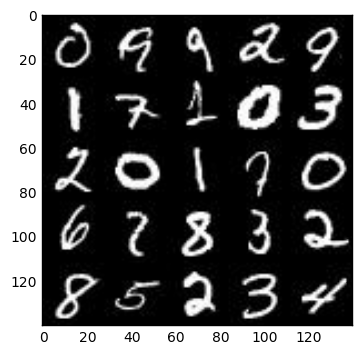

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

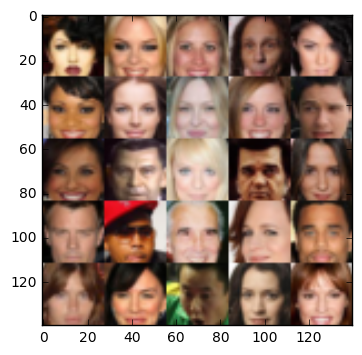

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width , image_height, image_channels), name='input_real')
    z_dim = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    return inputs_real, z_dim, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    def leaky_relu(x, alpha=0.2, name='leaky_relu'):
        return tf.maximum(x, alpha * x, name=name)
    
    xavier = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 32x32x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=xavier)
        relu1 = leaky_relu(x1, 0.2, name='leaky_relu1')
        relu1 = tf.layers.dropout(relu1, rate=0.5)
    
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, 0.2, name='leaky_relu2')
        relu2 = tf.layers.dropout(relu2, rate=0.5)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, 0.2, name='leaky_relu3')
        relu3 = tf.layers.dropout(relu3, rate=0.5)
        
        flat = tf.reshape(relu3, (-1 , 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2

    def leaky_relu(x, alpha=0.2, name='leaky_relu'):
        return tf.maximum(x, alpha * x, name=name)
    
    xavier = tf.contrib.layers.xavier_initializer()
    
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=xavier)
        # Reshape it 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        relu1 = leaky_relu(x1, 0.2, name='leaky_relu1')
        relu1 = tf.layers.dropout(relu1, rate=0.5, training=is_train)
        
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(bn2, 0.2, name='leaky_relu2')
        relu2 = tf.layers.dropout(relu2, rate=0.5, training=is_train)
        
 
      

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3, 0.2, name='leaky_relu3')
        relu3 = tf.layers.dropout(relu3, rate=0.5, training=is_train)
       
       
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        
   
        

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_model_real)*(1.0-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                               labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                               labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
tf.reset_default_graph()

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print("input_real", input_real)
    
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    
    d_opt , g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2
                steps +=1 
                
                # Sampe random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epochs {}/{}...".format(epoch_i+1, epoch_count), 
                         "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                    generator(input_z, data_shape[3], is_train=False), 
                                    feed_dict={input_z: sample_z})
                    
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 20 , input_z, data_shape[3], data_image_mode )
                    
            
            saver.save(sess, './checkpoints/generator.ckpt')
            
        
        
            
        return losses, samples
                    
             


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input_real Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32)
Epochs 1/2... Discriminator Loss: 0.5613... Generator Loss: 2.6445
Epochs 1/2... Discriminator Loss: 0.9912... Generator Loss: 1.1809
Epochs 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.3394
Epochs 1/2... Discriminator Loss: 0.6162... Generator Loss: 2.1861
Epochs 1/2... Discriminator Loss: 1.3331... Generator Loss: 3.7354
Epochs 1/2... Discriminator Loss: 0.9784... Generator Loss: 2.8398
Epochs 1/2... Discriminator Loss: 0.7770... Generator Loss: 1.6480
Epochs 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6134
Epochs 1/2... Discriminator Loss: 0.8577... Generator Loss: 2.5089
Epochs 1/2... Discriminator Loss: 1.7192... Generator Loss: 0.4278


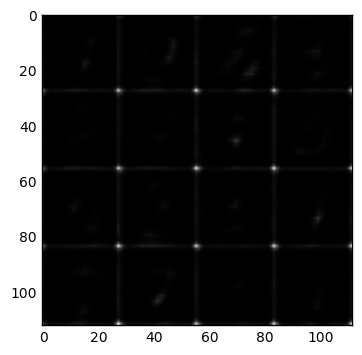

Epochs 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.8580
Epochs 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.7689
Epochs 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.5725
Epochs 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.3413
Epochs 1/2... Discriminator Loss: 0.6801... Generator Loss: 2.0410
Epochs 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.0451
Epochs 1/2... Discriminator Loss: 0.5977... Generator Loss: 1.8219
Epochs 1/2... Discriminator Loss: 0.5571... Generator Loss: 2.3615
Epochs 1/2... Discriminator Loss: 0.6010... Generator Loss: 2.1607
Epochs 1/2... Discriminator Loss: 0.5854... Generator Loss: 1.6994


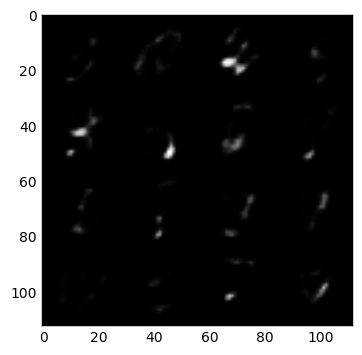

Epochs 1/2... Discriminator Loss: 0.8928... Generator Loss: 3.5983
Epochs 1/2... Discriminator Loss: 0.5409... Generator Loss: 2.0557
Epochs 1/2... Discriminator Loss: 0.7795... Generator Loss: 3.1831
Epochs 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.9057
Epochs 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.7522
Epochs 1/2... Discriminator Loss: 0.7556... Generator Loss: 2.7449
Epochs 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.9413
Epochs 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.7918
Epochs 1/2... Discriminator Loss: 0.5707... Generator Loss: 2.3555
Epochs 1/2... Discriminator Loss: 0.6520... Generator Loss: 1.4929


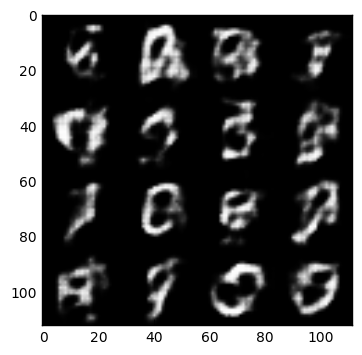

Epochs 1/2... Discriminator Loss: 0.6339... Generator Loss: 1.5814
Epochs 1/2... Discriminator Loss: 0.6268... Generator Loss: 2.2911
Epochs 1/2... Discriminator Loss: 0.8071... Generator Loss: 3.1815
Epochs 1/2... Discriminator Loss: 0.6024... Generator Loss: 2.7556
Epochs 1/2... Discriminator Loss: 0.5343... Generator Loss: 2.6785
Epochs 1/2... Discriminator Loss: 0.7243... Generator Loss: 1.6824
Epochs 1/2... Discriminator Loss: 1.1163... Generator Loss: 3.9183
Epochs 1/2... Discriminator Loss: 0.7588... Generator Loss: 3.1501
Epochs 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.7968
Epochs 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6832


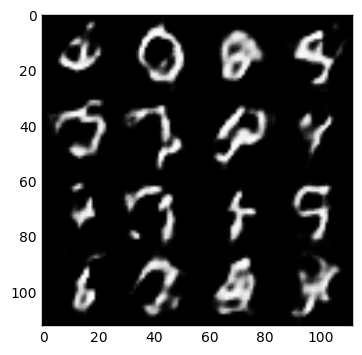

Epochs 1/2... Discriminator Loss: 0.7117... Generator Loss: 2.5603
Epochs 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.5401
Epochs 1/2... Discriminator Loss: 0.6573... Generator Loss: 2.0715
Epochs 1/2... Discriminator Loss: 0.7860... Generator Loss: 1.7721
Epochs 1/2... Discriminator Loss: 0.9397... Generator Loss: 1.0700
Epochs 1/2... Discriminator Loss: 1.2000... Generator Loss: 3.3802
Epochs 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.3032
Epochs 1/2... Discriminator Loss: 0.7528... Generator Loss: 2.5029
Epochs 1/2... Discriminator Loss: 0.8615... Generator Loss: 0.9602
Epochs 1/2... Discriminator Loss: 0.7282... Generator Loss: 1.4455


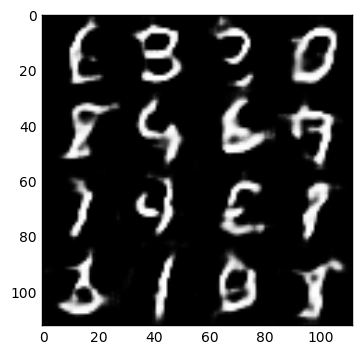

Epochs 1/2... Discriminator Loss: 0.6744... Generator Loss: 1.9713
Epochs 1/2... Discriminator Loss: 0.9445... Generator Loss: 3.2815
Epochs 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.6460
Epochs 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.2424
Epochs 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.0827
Epochs 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.7438
Epochs 1/2... Discriminator Loss: 0.8029... Generator Loss: 2.7250
Epochs 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.4595
Epochs 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.3812
Epochs 1/2... Discriminator Loss: 0.6631... Generator Loss: 2.2054


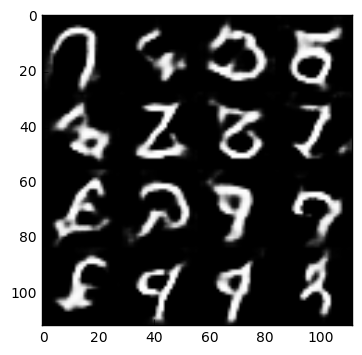

Epochs 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.7254
Epochs 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.0317
Epochs 1/2... Discriminator Loss: 1.0387... Generator Loss: 3.1207
Epochs 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.0032
Epochs 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.4313
Epochs 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.4932
Epochs 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.9688
Epochs 1/2... Discriminator Loss: 1.0035... Generator Loss: 2.8333
Epochs 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.4103
Epochs 1/2... Discriminator Loss: 0.5897... Generator Loss: 2.1767


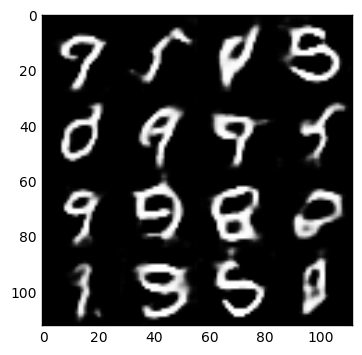

Epochs 1/2... Discriminator Loss: 0.7444... Generator Loss: 2.4508
Epochs 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.5321
Epochs 1/2... Discriminator Loss: 0.6561... Generator Loss: 1.4150
Epochs 1/2... Discriminator Loss: 0.6645... Generator Loss: 2.0661
Epochs 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.1868
Epochs 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.3027
Epochs 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.9904
Epochs 1/2... Discriminator Loss: 0.6410... Generator Loss: 2.3061
Epochs 1/2... Discriminator Loss: 0.6402... Generator Loss: 2.5309
Epochs 1/2... Discriminator Loss: 0.6579... Generator Loss: 1.6416


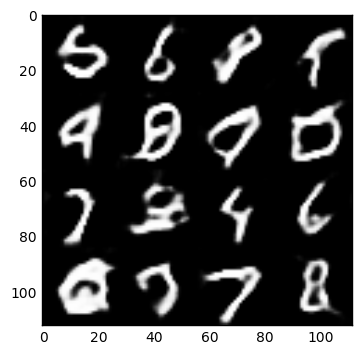

Epochs 1/2... Discriminator Loss: 0.5683... Generator Loss: 2.0715
Epochs 1/2... Discriminator Loss: 0.8420... Generator Loss: 2.6726
Epochs 1/2... Discriminator Loss: 0.6070... Generator Loss: 2.0717
Epochs 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.7544
Epochs 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.6435
Epochs 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.6186
Epochs 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.4164
Epochs 1/2... Discriminator Loss: 0.8053... Generator Loss: 2.8484
Epochs 1/2... Discriminator Loss: 0.6574... Generator Loss: 1.7865
Epochs 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.7369


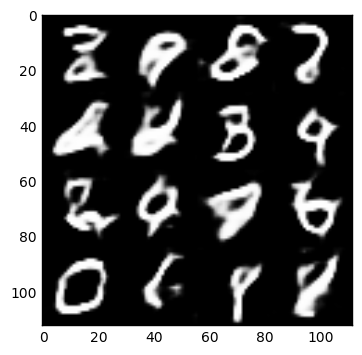

Epochs 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.9689
Epochs 1/2... Discriminator Loss: 0.5968... Generator Loss: 1.9479
Epochs 1/2... Discriminator Loss: 0.7441... Generator Loss: 2.8945
Epochs 2/2... Discriminator Loss: 0.6110... Generator Loss: 2.1892
Epochs 2/2... Discriminator Loss: 0.5925... Generator Loss: 1.9684
Epochs 2/2... Discriminator Loss: 0.6065... Generator Loss: 2.1798
Epochs 2/2... Discriminator Loss: 0.5951... Generator Loss: 1.9896
Epochs 2/2... Discriminator Loss: 0.6090... Generator Loss: 1.6504
Epochs 2/2... Discriminator Loss: 0.7573... Generator Loss: 2.7838
Epochs 2/2... Discriminator Loss: 0.6004... Generator Loss: 2.0034


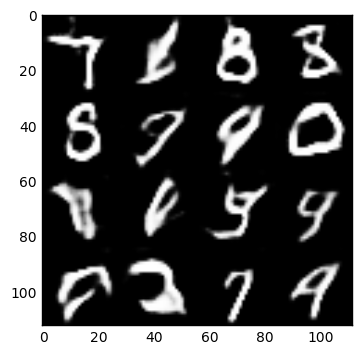

Epochs 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.1648
Epochs 2/2... Discriminator Loss: 0.6152... Generator Loss: 2.1122
Epochs 2/2... Discriminator Loss: 0.5731... Generator Loss: 1.9308
Epochs 2/2... Discriminator Loss: 0.5993... Generator Loss: 2.4170
Epochs 2/2... Discriminator Loss: 2.9563... Generator Loss: 0.3314
Epochs 2/2... Discriminator Loss: 0.7500... Generator Loss: 1.8993
Epochs 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.0993
Epochs 2/2... Discriminator Loss: 0.6009... Generator Loss: 2.0021
Epochs 2/2... Discriminator Loss: 0.5366... Generator Loss: 1.9727
Epochs 2/2... Discriminator Loss: 0.5690... Generator Loss: 1.9332


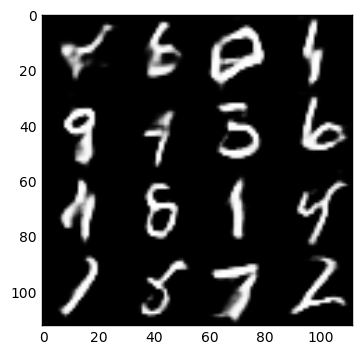

Epochs 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.7463
Epochs 2/2... Discriminator Loss: 0.6513... Generator Loss: 2.4165
Epochs 2/2... Discriminator Loss: 0.6325... Generator Loss: 2.3365
Epochs 2/2... Discriminator Loss: 0.6031... Generator Loss: 1.5258
Epochs 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.6114
Epochs 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.5070
Epochs 2/2... Discriminator Loss: 2.0412... Generator Loss: 4.5676
Epochs 2/2... Discriminator Loss: 0.5108... Generator Loss: 2.2011
Epochs 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.4373
Epochs 2/2... Discriminator Loss: 0.5923... Generator Loss: 2.0421


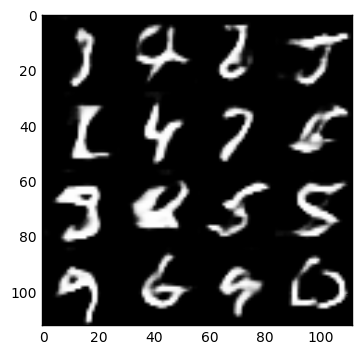

Epochs 2/2... Discriminator Loss: 0.5427... Generator Loss: 2.0363
Epochs 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.3400
Epochs 2/2... Discriminator Loss: 0.7511... Generator Loss: 1.3662
Epochs 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.5285
Epochs 2/2... Discriminator Loss: 0.5051... Generator Loss: 2.1352
Epochs 2/2... Discriminator Loss: 0.5607... Generator Loss: 1.5854
Epochs 2/2... Discriminator Loss: 0.7788... Generator Loss: 3.3632
Epochs 2/2... Discriminator Loss: 0.4528... Generator Loss: 2.4861
Epochs 2/2... Discriminator Loss: 0.4768... Generator Loss: 2.4736
Epochs 2/2... Discriminator Loss: 0.4820... Generator Loss: 2.4178


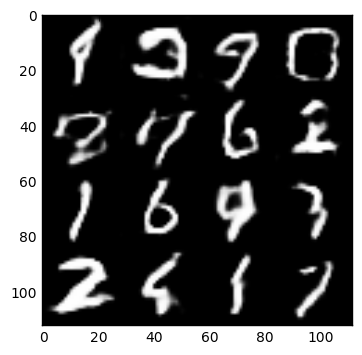

Epochs 2/2... Discriminator Loss: 0.5011... Generator Loss: 1.9855
Epochs 2/2... Discriminator Loss: 2.6570... Generator Loss: 0.2520
Epochs 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.2383
Epochs 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.6810
Epochs 2/2... Discriminator Loss: 0.5265... Generator Loss: 2.1334
Epochs 2/2... Discriminator Loss: 0.5886... Generator Loss: 2.4581
Epochs 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.6817
Epochs 2/2... Discriminator Loss: 0.5499... Generator Loss: 2.0044
Epochs 2/2... Discriminator Loss: 0.5752... Generator Loss: 1.9268
Epochs 2/2... Discriminator Loss: 0.9170... Generator Loss: 3.8871


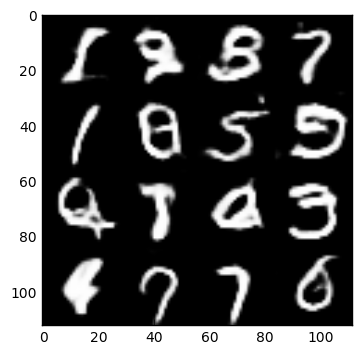

Epochs 2/2... Discriminator Loss: 0.7103... Generator Loss: 2.9713
Epochs 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.9964
Epochs 2/2... Discriminator Loss: 0.5609... Generator Loss: 2.1690
Epochs 2/2... Discriminator Loss: 0.6079... Generator Loss: 2.7887
Epochs 2/2... Discriminator Loss: 0.4871... Generator Loss: 2.2028
Epochs 2/2... Discriminator Loss: 0.4610... Generator Loss: 3.0540
Epochs 2/2... Discriminator Loss: 0.5517... Generator Loss: 2.0289
Epochs 2/2... Discriminator Loss: 0.5005... Generator Loss: 2.4997
Epochs 2/2... Discriminator Loss: 0.4433... Generator Loss: 3.0564
Epochs 2/2... Discriminator Loss: 0.5241... Generator Loss: 1.9844


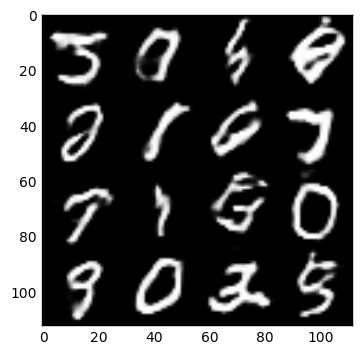

Epochs 2/2... Discriminator Loss: 2.9565... Generator Loss: 0.1625
Epochs 2/2... Discriminator Loss: 0.5362... Generator Loss: 2.4250
Epochs 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.2277
Epochs 2/2... Discriminator Loss: 0.5329... Generator Loss: 2.4900
Epochs 2/2... Discriminator Loss: 0.4573... Generator Loss: 2.6524
Epochs 2/2... Discriminator Loss: 0.5005... Generator Loss: 2.1482
Epochs 2/2... Discriminator Loss: 0.4631... Generator Loss: 2.2644
Epochs 2/2... Discriminator Loss: 0.5002... Generator Loss: 2.3466
Epochs 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.6797
Epochs 2/2... Discriminator Loss: 0.8947... Generator Loss: 2.5965


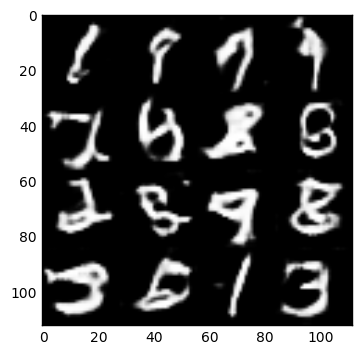

Epochs 2/2... Discriminator Loss: 0.5472... Generator Loss: 1.9134
Epochs 2/2... Discriminator Loss: 0.5892... Generator Loss: 2.2472
Epochs 2/2... Discriminator Loss: 0.4751... Generator Loss: 2.6440
Epochs 2/2... Discriminator Loss: 0.4869... Generator Loss: 2.6596
Epochs 2/2... Discriminator Loss: 0.4855... Generator Loss: 2.2998
Epochs 2/2... Discriminator Loss: 0.4907... Generator Loss: 2.6297
Epochs 2/2... Discriminator Loss: 0.4871... Generator Loss: 2.4261
Epochs 2/2... Discriminator Loss: 0.4761... Generator Loss: 2.7810
Epochs 2/2... Discriminator Loss: 0.4576... Generator Loss: 2.6686
Epochs 2/2... Discriminator Loss: 0.4436... Generator Loss: 2.5911


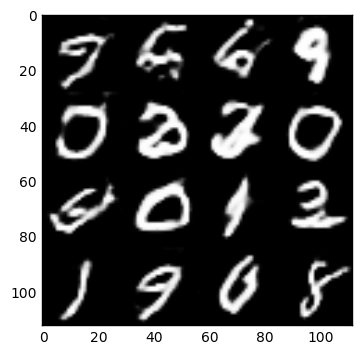

Epochs 2/2... Discriminator Loss: 0.4228... Generator Loss: 2.6623
Epochs 2/2... Discriminator Loss: 0.5166... Generator Loss: 2.4112
Epochs 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.4595
Epochs 2/2... Discriminator Loss: 0.5504... Generator Loss: 2.8364
Epochs 2/2... Discriminator Loss: 0.4560... Generator Loss: 2.8274
Epochs 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.6475
Epochs 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.5382
Epochs 2/2... Discriminator Loss: 0.4333... Generator Loss: 2.3794
Epochs 2/2... Discriminator Loss: 0.6104... Generator Loss: 2.4528
Epochs 2/2... Discriminator Loss: 0.5254... Generator Loss: 2.1577


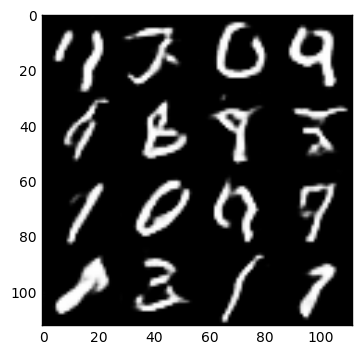

Epochs 2/2... Discriminator Loss: 0.5264... Generator Loss: 2.0256
Epochs 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.9318
Epochs 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.8431
Epochs 2/2... Discriminator Loss: 0.5313... Generator Loss: 1.9132
Epochs 2/2... Discriminator Loss: 2.1880... Generator Loss: 4.4582
Epochs 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.8277
Epochs 2/2... Discriminator Loss: 0.4511... Generator Loss: 2.7552


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input_real Tensor("input_real:0", shape=(?, 28, 28, 3), dtype=float32)
Epochs 1/1... Discriminator Loss: 0.4497... Generator Loss: 4.4033
Epochs 1/1... Discriminator Loss: 0.3733... Generator Loss: 4.1504
Epochs 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.5818
Epochs 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.2997
Epochs 1/1... Discriminator Loss: 0.5015... Generator Loss: 3.7995
Epochs 1/1... Discriminator Loss: 0.4360... Generator Loss: 3.1816
Epochs 1/1... Discriminator Loss: 0.4311... Generator Loss: 3.8898
Epochs 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.8920
Epochs 1/1... Discriminator Loss: 0.4846... Generator Loss: 2.7453
Epochs 1/1... Discriminator Loss: 0.3765... Generator Loss: 3.8067


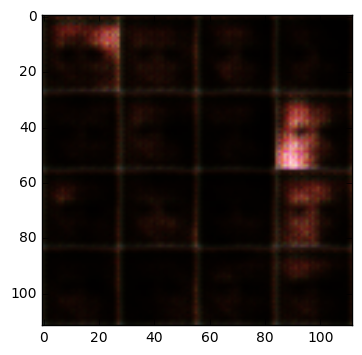

Epochs 1/1... Discriminator Loss: 0.4399... Generator Loss: 3.2244
Epochs 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.2362
Epochs 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.9506
Epochs 1/1... Discriminator Loss: 0.4219... Generator Loss: 4.0835
Epochs 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.7465
Epochs 1/1... Discriminator Loss: 0.3458... Generator Loss: 4.8261
Epochs 1/1... Discriminator Loss: 0.3462... Generator Loss: 4.9733
Epochs 1/1... Discriminator Loss: 0.3540... Generator Loss: 4.6590
Epochs 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.8076
Epochs 1/1... Discriminator Loss: 0.3956... Generator Loss: 6.6880


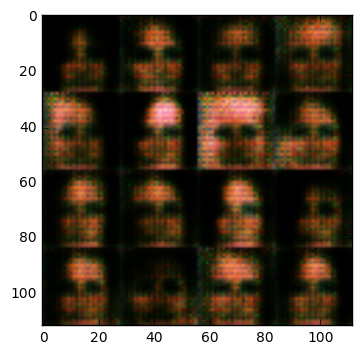

Epochs 1/1... Discriminator Loss: 0.3523... Generator Loss: 4.1006
Epochs 1/1... Discriminator Loss: 0.5105... Generator Loss: 3.7683
Epochs 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.7168
Epochs 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.2211
Epochs 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.8946
Epochs 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.6580
Epochs 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.3246
Epochs 1/1... Discriminator Loss: 0.3749... Generator Loss: 4.6133
Epochs 1/1... Discriminator Loss: 3.4768... Generator Loss: 10.2946
Epochs 1/1... Discriminator Loss: 0.4599... Generator Loss: 3.1332


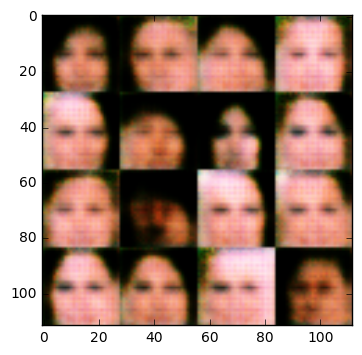

Epochs 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.6644
Epochs 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.1475
Epochs 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.5007
Epochs 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.9969
Epochs 1/1... Discriminator Loss: 0.4287... Generator Loss: 3.0873
Epochs 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.1920
Epochs 1/1... Discriminator Loss: 0.5145... Generator Loss: 4.5672
Epochs 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.4412
Epochs 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.6475
Epochs 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.5294


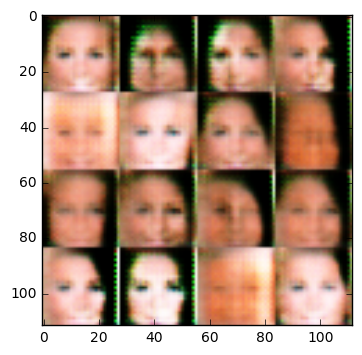

Epochs 1/1... Discriminator Loss: 0.5230... Generator Loss: 3.3165
Epochs 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.4738
Epochs 1/1... Discriminator Loss: 0.8224... Generator Loss: 5.8855
Epochs 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.7373
Epochs 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.1014
Epochs 1/1... Discriminator Loss: 0.4401... Generator Loss: 3.0080
Epochs 1/1... Discriminator Loss: 1.0158... Generator Loss: 5.9523
Epochs 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.2695
Epochs 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.7951
Epochs 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.1839


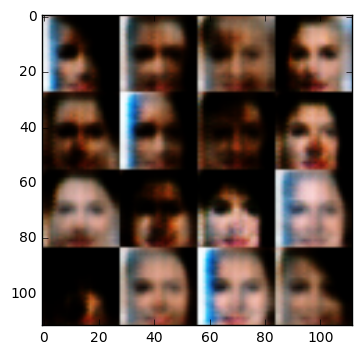

Epochs 1/1... Discriminator Loss: 0.4328... Generator Loss: 3.0841
Epochs 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.5215
Epochs 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.2194
Epochs 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.1448
Epochs 1/1... Discriminator Loss: 0.5474... Generator Loss: 2.2282
Epochs 1/1... Discriminator Loss: 0.5542... Generator Loss: 3.4586
Epochs 1/1... Discriminator Loss: 0.6079... Generator Loss: 2.0687
Epochs 1/1... Discriminator Loss: 0.6407... Generator Loss: 1.9758
Epochs 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.1310
Epochs 1/1... Discriminator Loss: 0.5535... Generator Loss: 2.7307


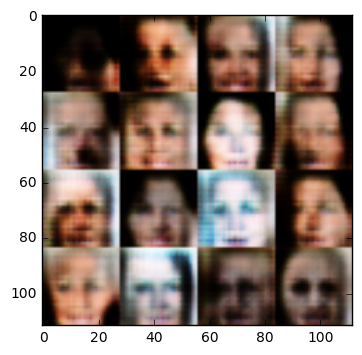

Epochs 1/1... Discriminator Loss: 0.5168... Generator Loss: 3.0982
Epochs 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.1326
Epochs 1/1... Discriminator Loss: 0.7948... Generator Loss: 3.9448
Epochs 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4942
Epochs 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.8592
Epochs 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.3635
Epochs 1/1... Discriminator Loss: 0.5910... Generator Loss: 2.7832
Epochs 1/1... Discriminator Loss: 0.5606... Generator Loss: 2.6508
Epochs 1/1... Discriminator Loss: 0.4811... Generator Loss: 3.8411
Epochs 1/1... Discriminator Loss: 0.7178... Generator Loss: 3.2858


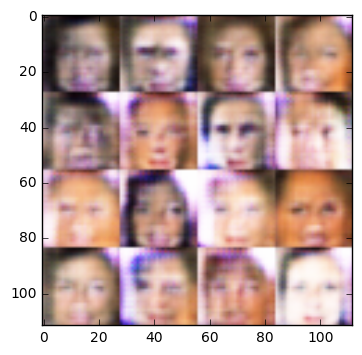

Epochs 1/1... Discriminator Loss: 0.7203... Generator Loss: 3.9687
Epochs 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.6534
Epochs 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.6871
Epochs 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.8906
Epochs 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.4886
Epochs 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.1424
Epochs 1/1... Discriminator Loss: 0.9435... Generator Loss: 3.3865
Epochs 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.9624
Epochs 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.4887
Epochs 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.3405


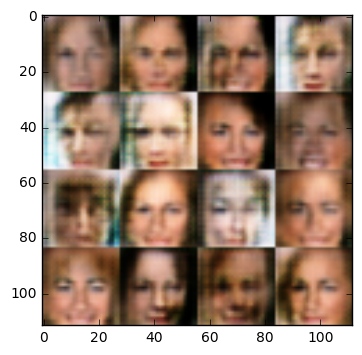

Epochs 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.4534
Epochs 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.5303
Epochs 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.7845
Epochs 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.8477
Epochs 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.6887
Epochs 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.2580
Epochs 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0804
Epochs 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.7444
Epochs 1/1... Discriminator Loss: 0.8129... Generator Loss: 2.1809
Epochs 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.9632


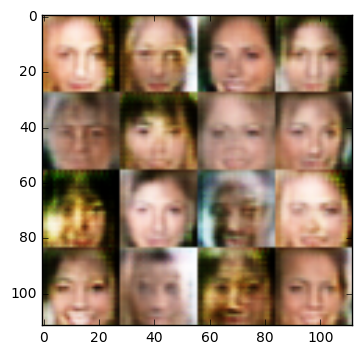

Epochs 1/1... Discriminator Loss: 0.8073... Generator Loss: 2.4955
Epochs 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.1865
Epochs 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.7076
Epochs 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.8973
Epochs 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.4989
Epochs 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0305
Epochs 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.5474
Epochs 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.3333
Epochs 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7048
Epochs 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.8039


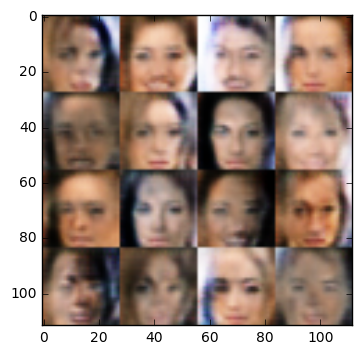

Epochs 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.7281
Epochs 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.0967


KeyboardInterrupt: 

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.